# Throne : Getting Started

This brief notebook provides an overview of the historical and competition data provided on the Throne platform and how you can manipulate it to make predictions. This is not a guide on how to make good models...the goal is show the simplest possible case of making predictions from the datasets.

## Data Analysis

Download the historical data for the competition you are interested in and read it into pandas:

In [1]:
import pandas as pd

data = pd.read_csv("nfl_historical_data.csv")

We can look at a sample of data:

In [2]:
data.tail()

,id,date,team_1_name,team_1_score,team_2_name,team_2_score,d_ability_1,p_ability_1,p_ability_2,d_h2h_1,travel_3
2266,59f66da44825082f460396bb,2017-11-05 21:05:00,San Francisco 49ers,10.0,Arizona Cardinals,20.0,-0.971559,-0.718991,-0.727342,-0.982032,0.638009
2267,59f66da44825082f460396bc,2017-11-05 21:05:00,Seattle Seahawks,14.0,Washington Redskins,17.0,0.881656,0.792743,0.788140,0.672087,3.025060
2268,59f66da44825082f460396bd,2017-11-05 21:25:00,Dallas Cowboys,28.0,Kansas City Chiefs,17.0,-0.384072,-0.105095,-0.199489,0.289570,-0.555517
2269,59f66da44825082f460396be,2017-11-06 01:30:00,Miami Dolphins,24.0,Oakland Raiders,27.0,-0.429832,-0.800122,-0.917392,1.566252,-0.555517
2270,59f66da44825082f460396bf,2017-11-07 01:30:00,Green Bay Packers,17.0,Detroit Lions,30.0,0.426982,-0.506403,-0.373444,0.482297,0.638009


Let's look at the data in more detail. We can use the **pandas_profiling library** to profile the data:

In [3]:
import pandas_profiling
pandas_profiling.ProfileReport(data)

Number of variables,11
Number of observations,2271
Total Missing (%),0.1%
Total size in memory,195.2 KiB
Average record size in memory,88.0 B
Numeric,5
Categorical,3
Date,0
Text (Unique),1
Rejected,2
Distinct count,2254


We can use UMAP (an alternative to t-SNE) for dimensionality reduction and data visualization of our features:

In [4]:
import umap

features = data[['d_ability_1', 'p_ability_1', 'p_ability_2', "d_h2h_1", "travel_3"]].dropna()
feature_values = features.values
embedding = umap.UMAP().fit_transform(feature_values)

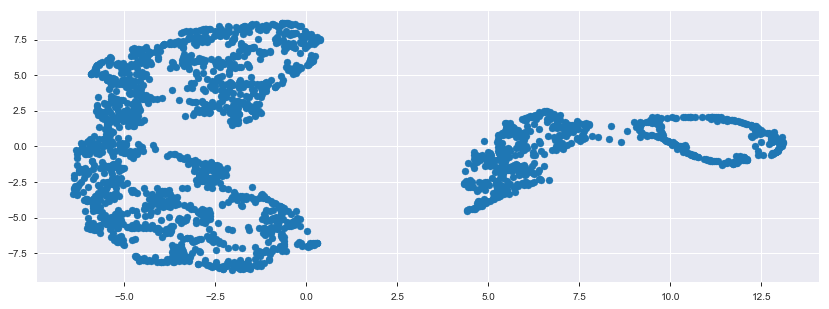

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14,5))
plt.scatter(embedding.T[0], embedding.T[1])

We can get an idea of the key components driving variation by highlighting various features based on their values. For example, let's highlight the **d_ability_1** feature when it is above or below average:

In [6]:
import numpy as np

features = data[['d_ability_1', 'p_ability_1', 'p_ability_2', "d_h2h_1", "travel_3"]].dropna()
home_favorite = list(range((features.shape[0])))
home_favorite = [i for i in home_favorite if features['d_ability_1'].iat[i] > 0.0]
away_favorite = [i for i in range((features.shape[0])) if i not in home_favorite]

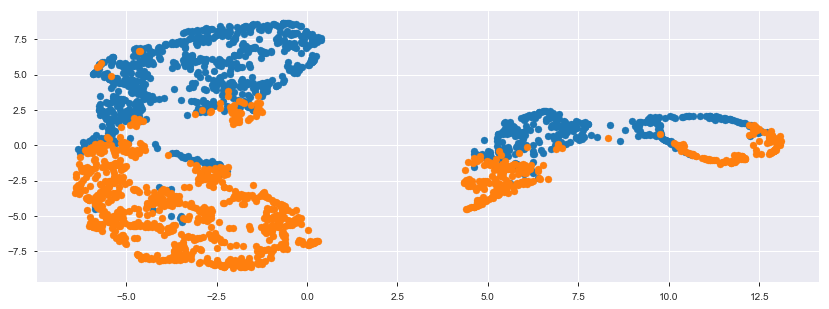

In [7]:
plt.figure(figsize=(14,5))
plt.scatter(embedding.T[0][[home_favorite]], embedding.T[1][[home_favorite]])
plt.scatter(embedding.T[0][[away_favorite]], embedding.T[1][[away_favorite]])

It appears an ability component is determining the y-axis component. We can also do the same for the **travel_3** factor:

In [8]:
home_plus_travel = list(range((features.shape[0])))
home_plus_travel = [i for i in home_plus_travel if features['travel_3'].iat[i] > 0.0]
away_travel = [i for i in range((features.shape[0])) if i not in home_plus_travel]

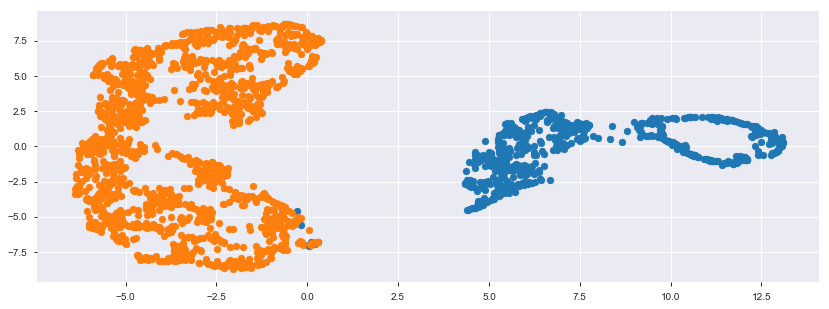

In [9]:
plt.figure(figsize=(14,5))
plt.scatter(embedding.T[0][[home_plus_travel]], embedding.T[1][[home_plus_travel]])
plt.scatter(embedding.T[0][[away_travel]], embedding.T[1][[away_travel]])

The travel component appears to explain the variation in the x-axis component.

## Using Data to Make Predictions

A proper process involves feature engineering, selection, cross-validation, hyperparameter tuning, model selection, ensembles and other parts of the standard data science toolkit. Here we will merely show a simple example of using the data above to make predictions (you should do the rest!).

With sports data, we could simply treat the problem as a classification problem (win/loss) data. Here we are going to employ a different approach based on the point spread. We can make a **point_spread** variable as follows:

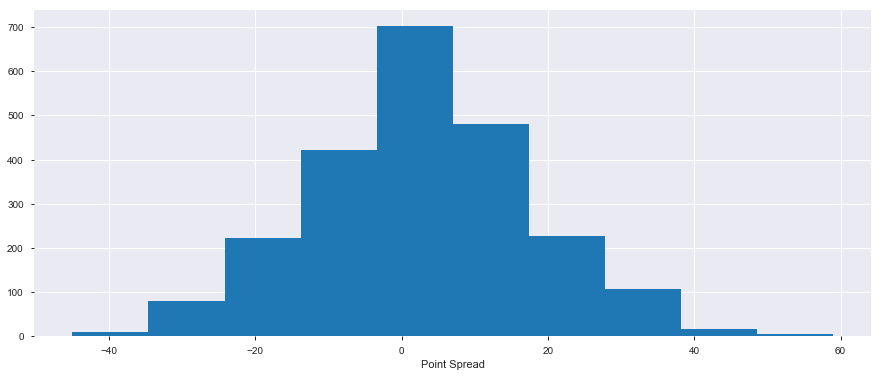

In [10]:
data['point_spread'] = data['team_1_score'] - data['team_2_score']

plt.figure(figsize=(15, 6))
plt.hist(data['point_spread']);
plt.xlabel('Point Spread');

Now we are going to remove any rows with missing values - you should question whether this is sensible or not - and make simple target and feature data sets:

In [11]:
feature_cols = ['d_ability_1', 'p_ability_1', 'p_ability_2', "d_h2h_1", "travel_3"]

new_data = data.dropna()
y = np.array([new_data['point_spread'].values]).T
X = new_data[feature_cols].values

Let's run a simple **linear regression** with this data:

In [12]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression(fit_intercept=True)
reg.fit(X, y)
print(dict(zip(feature_cols, reg.coef_[0])))

{'p_ability_2': 4.8450312218975089, 'p_ability_1': -0.31411890270427989, 'd_ability_1': 1.6810827950437452, 'd_h2h_1': -0.68937266911407213, 'travel_3': -0.039569033855078699}


The fitted point spread can be viewed as follows:

In [13]:
fitted_point_spread = reg.predict(X)
print(fitted_point_spread)

[[ 5.60686597]
 [ 0.38811645]
 [ 3.18840885]
 ..., 
 [ 0.76723677]
 [-3.44973932]
 [ 1.23384139]]


To turn the point spread predictions into win probabilities, we need to either model the distribution of the point spread. Let's assume it is normally distributed. We then need a measure of point spread variance, either from the regression or emprical distribution. Then we can use the Normal Distribution CDF to back out probabilities:

In [14]:
import scipy.stats as stats
home_prob = stats.norm.cdf(fitted_point_spread, loc=0, scale=np.std(new_data['point_spread']))
print(home_prob)

[[ 0.64659438]
 [ 0.51038616]
 [ 0.58468652]
 ..., 
 [ 0.52052483]
 [ 0.40849071]
 [ 0.53298416]]


The reason why we generally favour modelling the point spread is that it contains more information than win/loss data alone. Of course, the assumptions made above are incredibly simplistic, but it illustrates the basic principle of modelling the spread and then using predicted spread to model win probabilities.

## Submitting Predictions to Throne

Let's suppose we had a model that we were satisfied with, after extensive engineering, tuning and backtesting, and wanted to submit predictions to Throne.ai. We would first obtain the competition data:

In [15]:
import pandas as pd

comp_data = pd.read_csv("nfl_competition_data.csv")

In [16]:
comp_data.head()

,id,date,team_1_name,team_2_name,d_ability_1,p_ability_1,p_ability_2,d_h2h_1,travel_3,team_1_prob,team_2_prob
0,5a001fb6482508091345b0ed,2017-11-12 18:00:00,Buffalo Bills,New Orleans Saints,-0.487455,-0.375473,-0.220085,-0.243192,-0.555517,NaN,NaN
1,5a001fb6482508091345b0ee,2017-11-12 18:00:00,Chicago Bears,Green Bay Packers,-0.909144,0.337571,0.364948,-2.209057,-0.555517,NaN,NaN
2,5a001fb6482508091345b0ef,2017-11-12 18:00:00,Detroit Lions,Cleveland Browns,1.587663,1.321528,1.250467,0.644288,-0.555517,NaN,NaN
3,5a001fb6482508091345b0f0,2017-11-12 18:00:00,Indianapolis Colts,Pittsburgh Steelers,-1.470637,-1.674630,-1.622619,-2.858098,-0.555517,NaN,NaN
4,5a001fb6482508091345b0f1,2017-11-12 18:00:00,Jacksonville Jaguars,Los Angeles Chargers,0.277541,0.444904,0.378411,-2.182455,-0.555517,NaN,NaN


This data contains information on upcoming games. We can see the **team_1_prob** and **team_2_prob** columns are blank. These columns are where we can enter our predictions. Let's use our model we made earlier to make predictions.

In [17]:
X_pred = comp_data[feature_cols].values
point_spread_pred = reg.predict(X_pred).T[0]
comp_data['team_1_prob'] = stats.norm.cdf(point_spread_pred, loc=0, scale=np.std(new_data['point_spread']))
comp_data['team_2_prob'] = 1.0 - comp_data['team_1_prob']
comp_data.head()

,id,date,team_1_name,team_2_name,d_ability_1,p_ability_1,p_ability_2,d_h2h_1,travel_3,team_1_prob,team_2_prob
0,5a001fb6482508091345b0ed,2017-11-12 18:00:00,Buffalo Bills,New Orleans Saints,-0.487455,-0.375473,-0.220085,-0.243192,-0.555517,0.525297,0.474703
1,5a001fb6482508091345b0ee,2017-11-12 18:00:00,Chicago Bears,Green Bay Packers,-0.909144,0.337571,0.364948,-2.209057,-0.555517,0.611006,0.388994
2,5a001fb6482508091345b0ef,2017-11-12 18:00:00,Detroit Lions,Cleveland Browns,1.587663,1.321528,1.250467,0.644288,-0.555517,0.757616,0.242384
3,5a001fb6482508091345b0f0,2017-11-12 18:00:00,Indianapolis Colts,Pittsburgh Steelers,-1.470637,-1.674630,-1.622619,-2.858098,-0.555517,0.361299,0.638701
4,5a001fb6482508091345b0f1,2017-11-12 18:00:00,Jacksonville Jaguars,Los Angeles Chargers,0.277541,0.444904,0.378411,-2.182455,-0.555517,0.661535,0.338465


We now simply have to save this csv, and then upload it to the platform. On the **Upcoming Fixtures** page we will be able to see who we are backing relative to the public. When events have occurred, we will then see our ranking and XP update in accordance with how good our predictions were.

In [19]:
comp_data.to_csv("my_predictions.csv")